### ECG Signals - SPEK

In this notebook we explore spectrograms as input representation for our deep learning model.

In [1]:
import torch
import torchaudio 
import wfdb
import sys
import wfdb
import matplotlib.pyplot as plt
import librosa.display

print('Virtual Environment:')
print(sys.prefix)

Virtual Environment:
/Users/piedeboer/Desktop/Thesis/code/signal-denoising/venv


#### Updated Spectrogram Methods

Square tensors (spectrograms) are obtained by taking the right values for samples_to, n_fft and hop_length.

A bigger problem is the reconstruction part. We lose phase information, which means we will have to work with a lossy reconstruction. PytorchAudio has a Griffin Lim implementation we use for now. The probably best approach would be to use gradient ascent. Additional recources.

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 



Approach 1:

- Using lossy conversion with Griffin [PytorchAudio]

In [2]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

Min value: tensor(1.4671e-07, dtype=torch.float64)
Max value: tensor(1024.7945, dtype=torch.float64)
Min value after taking log: tensor(-6.8336, dtype=torch.float64)
Max value after taking log: tensor(3.0106, dtype=torch.float64)


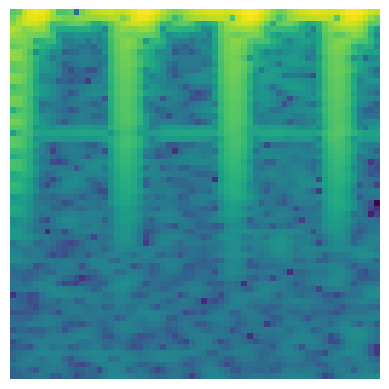

Griffin Time... torch.Size([1, 64, 64])


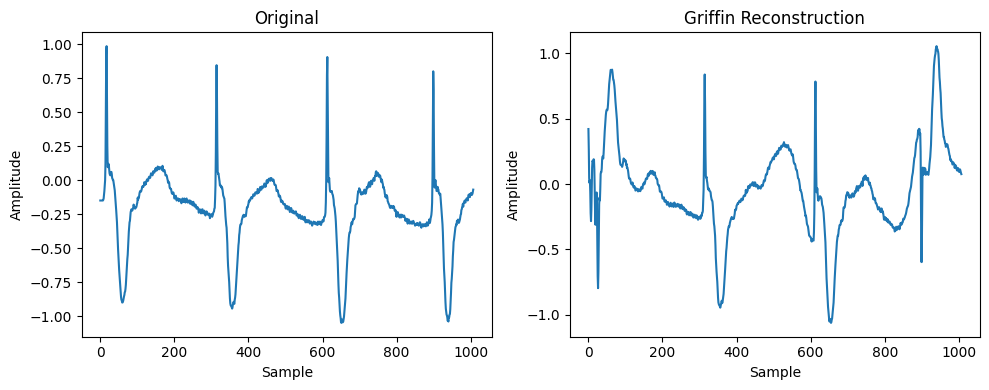

Number of samples: 1008
Duration in seconds: 2.8


In [7]:
def visualize_tensor(tensor):
    """
    Visualize a tensor as an image.
    
    Parameters:
    tensor (torch.Tensor): The input tensor with shape [3, 540, 540].
    """
    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()


def ecg_to_spectrogram_log(ecg_signal, n_fft=32, hop_length=4):
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)
    spec = spectrogram[0]   ## this is already the abs of STFT 'positive'

    # Check the range of values in the spectrogram
    print('Min value:', torch.min(spec))
    print('Max value:', torch.max(spec))

    # Take log 
    spec_log = torch.log10(spec)

    # Check the range of values after taking the absolute value
    print('Min value after taking log:', torch.min(spec_log))
    print('Max value after taking log:', torch.max(spec_log))

    return spec_log

def spectrogram_log_to_ecg(spec_log, n_fft=32, hop_length=None,n_iter=400):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
  
    # Undo log operation
    spec = torch.pow(10, spec_log)

    # Debugging purpose
    print('Griffin Time...', spec.shape)

    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft,  n_iter=400, hop_length=hop_length)(spec)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal

# Visualize Spek
def plot_spec(spec, title):
    """
    Plot spectrogram.

    Args:
    - spec (torch.Tensor): Spectrogram tensor.
    - title (str): Title of the plot.
    """
    plt.title(title)
    plt.imshow(librosa.amplitude_to_db(spec.numpy()), origin="lower", aspect="auto")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

######### Parameters ##########
samples_to = (62*16) + 16
n_fft = 126
hop_length = 16

# Load Data
path_102 = "data/ardb/104"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]
signal_102 = signal_102

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = -reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)


In [ ]:
######### Parameters ##########
samples_to = ((62*8*4) + 16) + 32
n_fft = 63*4 + 2
hop_length = 16

print('Duration in seconds...', samples_to/360)

# Load Data
path_102 = "data/nstdb/em"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]
signal_102 = signal_102

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)

#### Advanced Reconstruction

Gradient descent...

In [14]:
import numpy as np
# Undo log operation
spek_abs = torch.pow(10, spek_log)
print(spek_abs)

print(type(spek_abs))
print(spek_abs.shape)

# Conver to numpy
spek_abs_np = spek_abs.detach().cpu().numpy()
spek_abs_np = np.squeeze(spek_abs_np)

print(spek_abs_np)
print(spek_abs_np.shape)


########


tensor([[[2.8166e+00, 5.2845e+00, 1.3199e+02,  ..., 3.9036e+02,
          1.5885e+02, 1.0558e+02],
         [6.6054e+00, 3.3787e+01, 1.7424e+02,  ..., 1.3383e+02,
          2.5903e+01, 7.5591e+00],
         [1.5580e+01, 6.1026e+01, 1.5553e+02,  ..., 2.0871e+01,
          3.6234e+00, 3.7548e+00],
         ...,
         [8.8094e-04, 1.2079e-03, 1.6104e-03,  ..., 2.0104e-03,
          1.5946e-03, 1.2409e-03],
         [2.1306e-04, 5.2320e-04, 6.6832e-04,  ..., 2.7287e-03,
          2.0977e-03, 8.7050e-04],
         [1.9458e-04, 2.0824e-04, 4.4728e-04,  ..., 5.1440e-03,
          6.2192e-03, 7.1681e-03]]], dtype=torch.float64)
<class 'torch.Tensor'>
torch.Size([1, 64, 64])
[[2.81664948e+00 5.28448519e+00 1.31992551e+02 ... 3.90364686e+02
  1.58849748e+02 1.05576333e+02]
 [6.60539000e+00 3.37866695e+01 1.74235445e+02 ... 1.33832628e+02
  2.59026159e+01 7.55906292e+00]
 [1.55804784e+01 6.10258846e+01 1.55532192e+02 ... 2.08711522e+01
  3.62339737e+00 3.75477443e+00]
 ...
 [8.80944954e-04 1.2

Leap of faith: Matlab inside python...

In [17]:
%pip install matlabengine

ERROR: Ignored the following versions that require a different python version: 23.2.1 Requires-Python >=3.9, <3.12; 23.2.2 Requires-Python >=3.9, <3.12; 23.2.3 Requires-Python >=3.9, <3.12; 24.1.1 Requires-Python <3.12,>=3.9; 24.1.2 Requires-Python <3.12,>=3.9; 9.10.1 Requires-Python >=3.7, <3.9; 9.10.3 Requires-Python >=3.7, <3.9; 9.10.4 Requires-Python >=3.7, <3.9; 9.10.5 Requires-Python >=3.7, <3.9; 9.11.19 Requires-Python >=3.7, <3.10; 9.11.21 Requires-Python >=3.7, <3.10; 9.11.22 Requires-Python >=3.7, <3.10; 9.11.23 Requires-Python >=3.7, <3.10; 9.12 Requires-Python >=3.8, <3.10; 9.12.10 Requires-Python >=3.8, <3.10; 9.12.12 Requires-Python >=3.8, <3.10; 9.12.14 Requires-Python >=3.8, <3.10; 9.12.15 Requires-Python >=3.8, <3.10; 9.12.16 Requires-Python >=3.8, <3.10; 9.12.17 Requires-Python >=3.8, <3.10; 9.12.19 Requires-Python >=3.8, <3.10; 9.12.20 Requires-Python >=3.8, <3.10; 9.12.21 Requires-Python >=3.8, <3.10; 9.13.1 Requires-Python >=3.8, <3.11; 9.13.10 Requires-Python >=3.

In [18]:
import matlab.engine
eng = matlab.engine.start_matlab()

ModuleNotFoundError: No module named 'matlab.engine'; 'matlab' is not a package